In [1]:
%run -i 'cosim_import.py'
import csv

1.7.2.post287.dev0+gfaa45266
2.9.0


In [2]:
caseH = 18
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2669 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1195 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0669 seconds.


In [3]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1240 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0182 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0180 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0107 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4910.307


pp cost=2224.8754288341006, gb cost=4910.307428177317


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,1002.8172,90.1720,15.9217,1.0,1002.8172
1,646.0000,310.9533,1.9535,1.0,646.0000
2,290.0000,148.8141,-1.1572,1.0,290.0000
3,652.0000,129.6577,6.9360,1.0,652.0000
4,508.0000,145.0387,5.1048,1.0,508.0000
5,668.5448,225.0957,6.4636,1.0,668.5448
6,232.0000,60.4667,3.2560,1.0,232.0000
7,564.0000,-26.0077,13.4712,1.0,564.0000
8,865.0000,115.2992,15.9236,1.0,865.0000
9,-39.9433,0.0000,15.9236,1.0,-39.9433


In [4]:
import matplotlib.pyplot as plt

plt.style.use('ieee')

In [5]:
import matplotlib.font_manager

ANDES total load is: 58.564 p.u.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


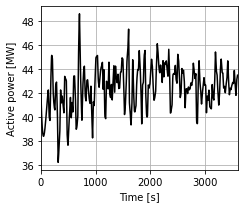

In [6]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 0.8*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 0.7
if caseH == 18:
    d_syn['sload'] = 0.8*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 0.7

# extensify load fluctuation
avg = d_syn['sload'].rolling(50).mean()
d_syn['sload'] = 15 * (d_syn['sload'] - avg) + avg
d_syn['sload'] *= ptotal

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

plt.style.use('ieee')
# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(3.5, 3))
ax_load.plot(d_syn['time'], d_syn['sload'], linestyle='-')
ax_load.set_xlim([0, 3600])
ax_load.set_ylabel('Active power [MW]')
ax_load.set_xlabel('Time [s]')
ax_load.grid()
plt.tight_layout()
fig_load.savefig("load_curve.png", bbox_inches="tight")

In [7]:
reader = csv.reader(open('cosim_18_F_rted.csv', 'r'))
pgf = pd.read_csv('cosim_18_F_pg.csv')
pgs = pd.read_csv('cosim_18_S_pg.csv')
agcf = pd.read_csv('cosim_18_F_agcm.csv')
agcs = pd.read_csv('cosim_18_S_agcm.csv')
outf = pd.read_csv('cosim_18_F_out.csv')
outs = pd.read_csv('cosim_18_S_out.csv')
evf = pd.read_csv('cosim_18_F_sse.csv')
evs = pd.read_csv('cosim_18_S_sse.csv')
evagcf = pd.read_csv('cosim_18_F_evagc.csv')
evagcs = pd.read_csv('cosim_18_S_evagc.csv')

rted_res = {}
for row in reader:
   k, v = row
   rted_res[k] = v

In [8]:
import matplotlib.font_manager

In [9]:
# --- generation cost ---
gtf = 0
gts = 0
for i in pgf.index:
    cf = ssd.cost.c2.values * np.power(pgf.loc[i].values, 2) \
        + ssd.cost.c1.values * pgf.loc[i].values \
        + ssd.cost.c1.values
    cs = ssd.cost.c2.values * np.power(pgs.loc[i].values, 2) \
        + ssd.cost.c1.values * pgs.loc[i].values \
        + ssd.cost.c1.values
    gtf += np.sum(cf)
    gts += np.sum(cs)

# --- SFR mileage cost ---
ftf = 0
fts = 0
for i in agcf.columns:
    cf = ssd.cost.c1.abs().values * agcf[i].values
    cs = ssd.cost.c1.abs().values * agcs[i].values
    ftf += np.sum(cf)
    fts += np.sum(cs)

print(f"EV AGC Mile: case1: {agcf.loc[9].sum()}, case2: {agcs.loc[9].sum()}")
print(f"Total cost: Case 2={np.round(gtf+ftf, 2)}, Case 1={np.round(gts+fts, 2)}")

EV AGC Mile: case1: 2070.0212268452733, case2: 0.0
Total cost: Case 2=139399.92, Case 1=153128.29


In [10]:
import matplotlib.font_manager

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


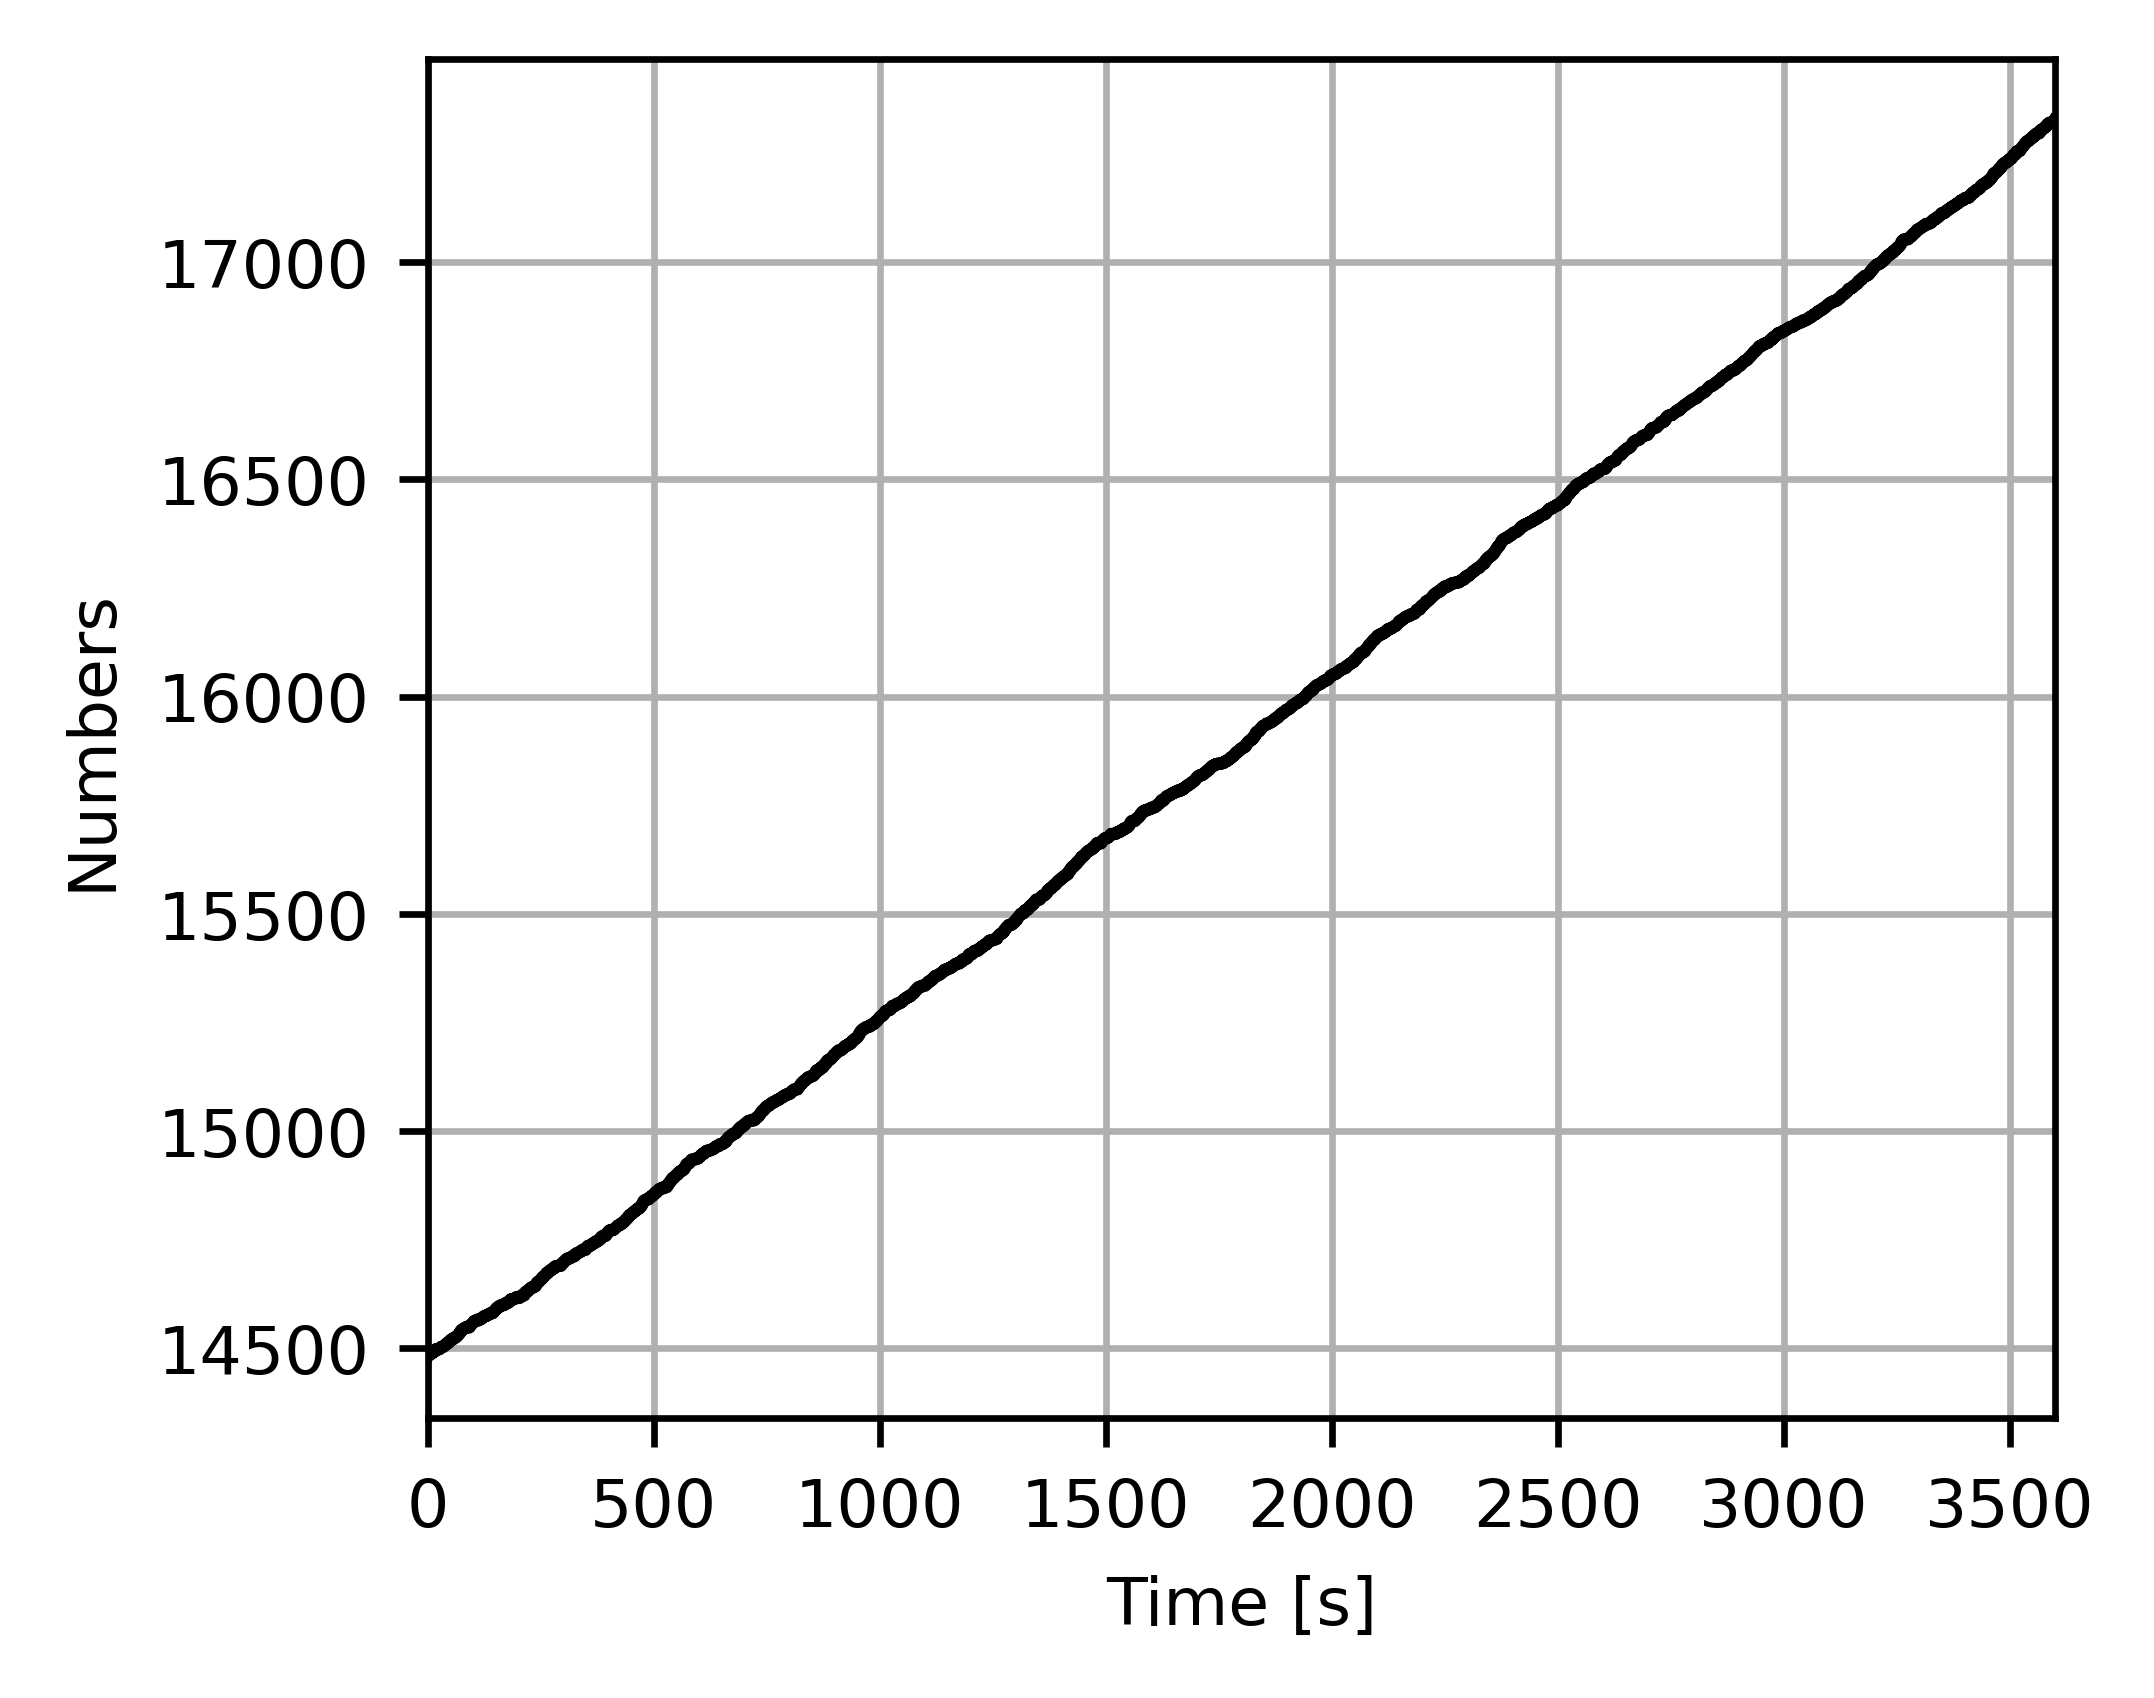

In [11]:
plt.style.use('ieee')
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.plot(3600*(np.array(evs.time)-18), evs['ne'])
ax.set_xlim([0, 3600])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Numbers')
ax.grid()

Text(0, 0.5, 'G9 AGC response [MW]')

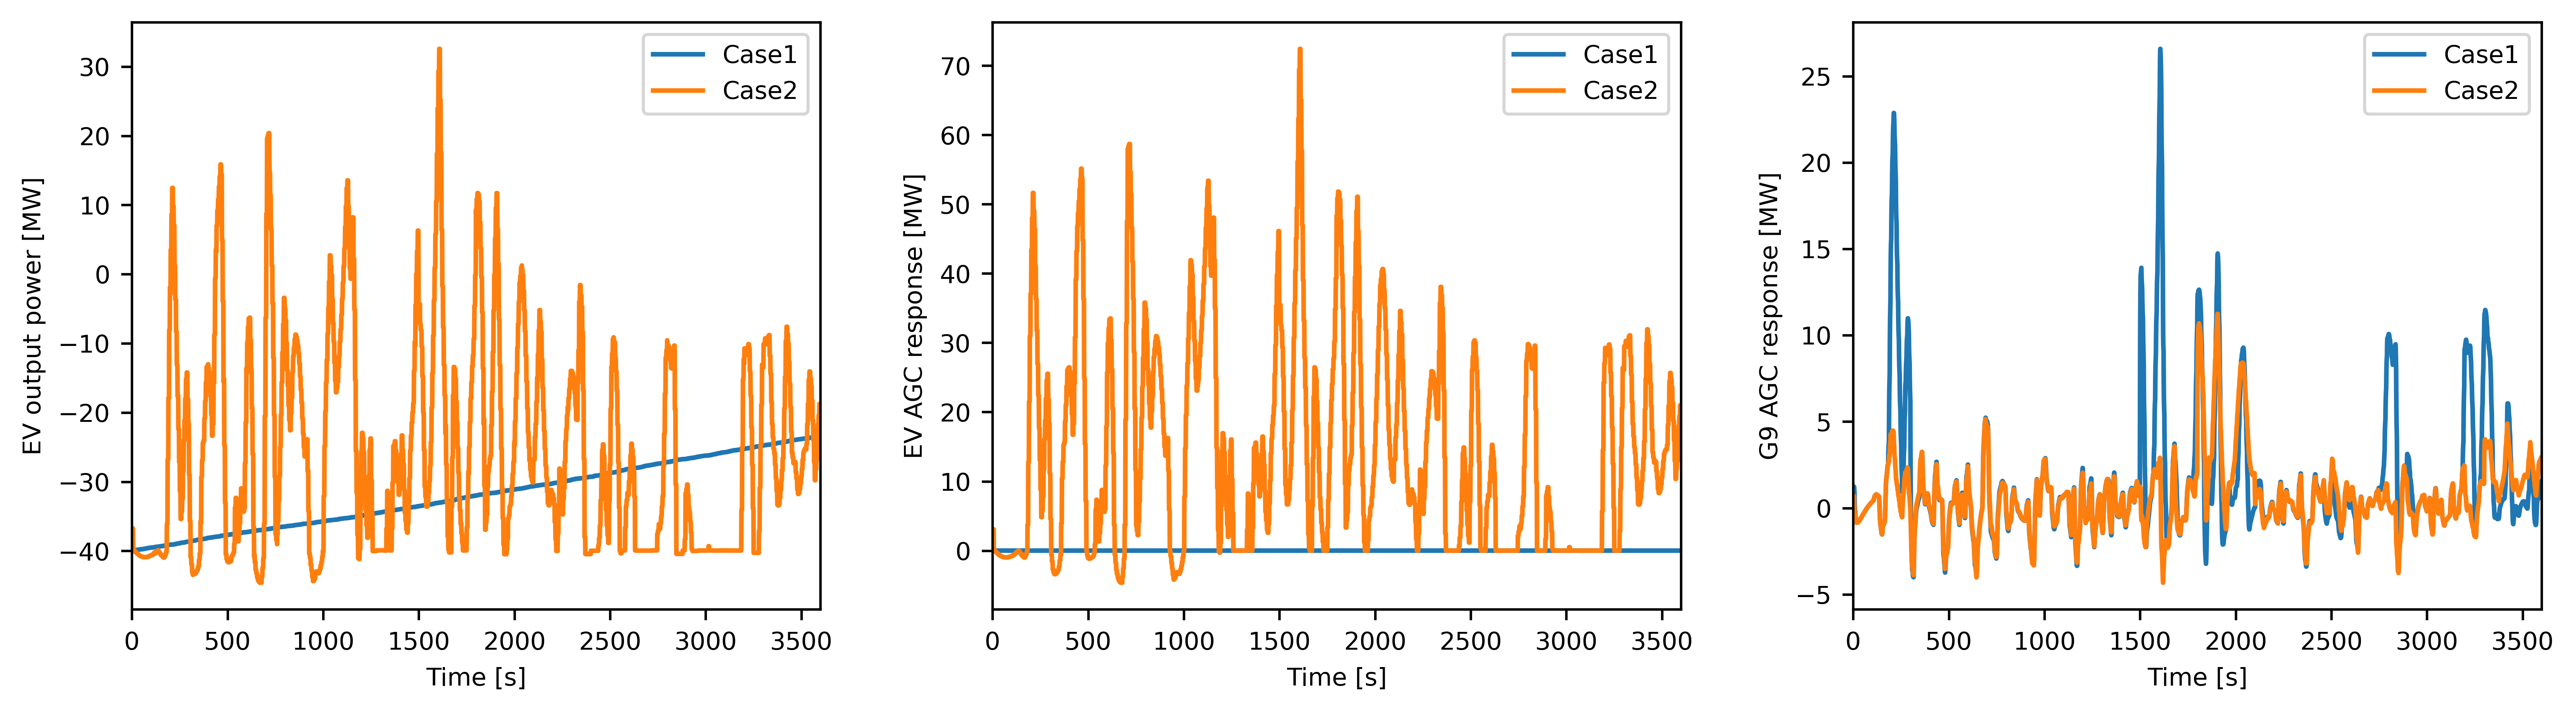

In [12]:
plt.style.use('ieee')
fig, ax = plt.subplots(1, 3, figsize=(14, 3.5))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.25, hspace=None)


ax[0].plot(3600*(np.array(evs.time)-18), evs.Pt, label='Case1', linestyle='-', color='tab:blue')
ax[0].plot(3600*(np.array(evs.time)-18), evf.Pt, label='Case2', linestyle='-', color='tab:orange')

ax[0].legend()
ax[0].set_xlim([0, 3600])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('EV output power [MW]')

outs.plot(x='Time', y='paux9', ax=ax[2], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outf.plot(x='Time', y='paux9', ax=ax[2], fig=fig, label='Case2', linestyle='-', color='tab:orange')

ax[1].plot(3600*(np.array(evs.time)-18), evs.Pr, label='Case1', linestyle='-', color='tab:blue')
ax[1].plot(3600*(np.array(evs.time)-18), evf.Pr, label='Case2', linestyle='-', color='tab:orange')
ax[1].legend()
ax[1].set_xlim([0, 3600])
ax[2].set_xlim([0, 3600])
ax[1].set_ylim(ax[1].get_ylim())
ax[1].set_xlabel('Time [s]')
ax[2].set_xlabel('Time [s]')
ax[1].set_ylabel('EV AGC response [MW]')
ax[2].set_ylabel('G9 AGC response [MW]')

Case1: Freq. D. 0.004800860512781374, Case2: 0.004585786068341165
Case1: ACE D. 16.83015290233063, Case2: 16.061424387741603


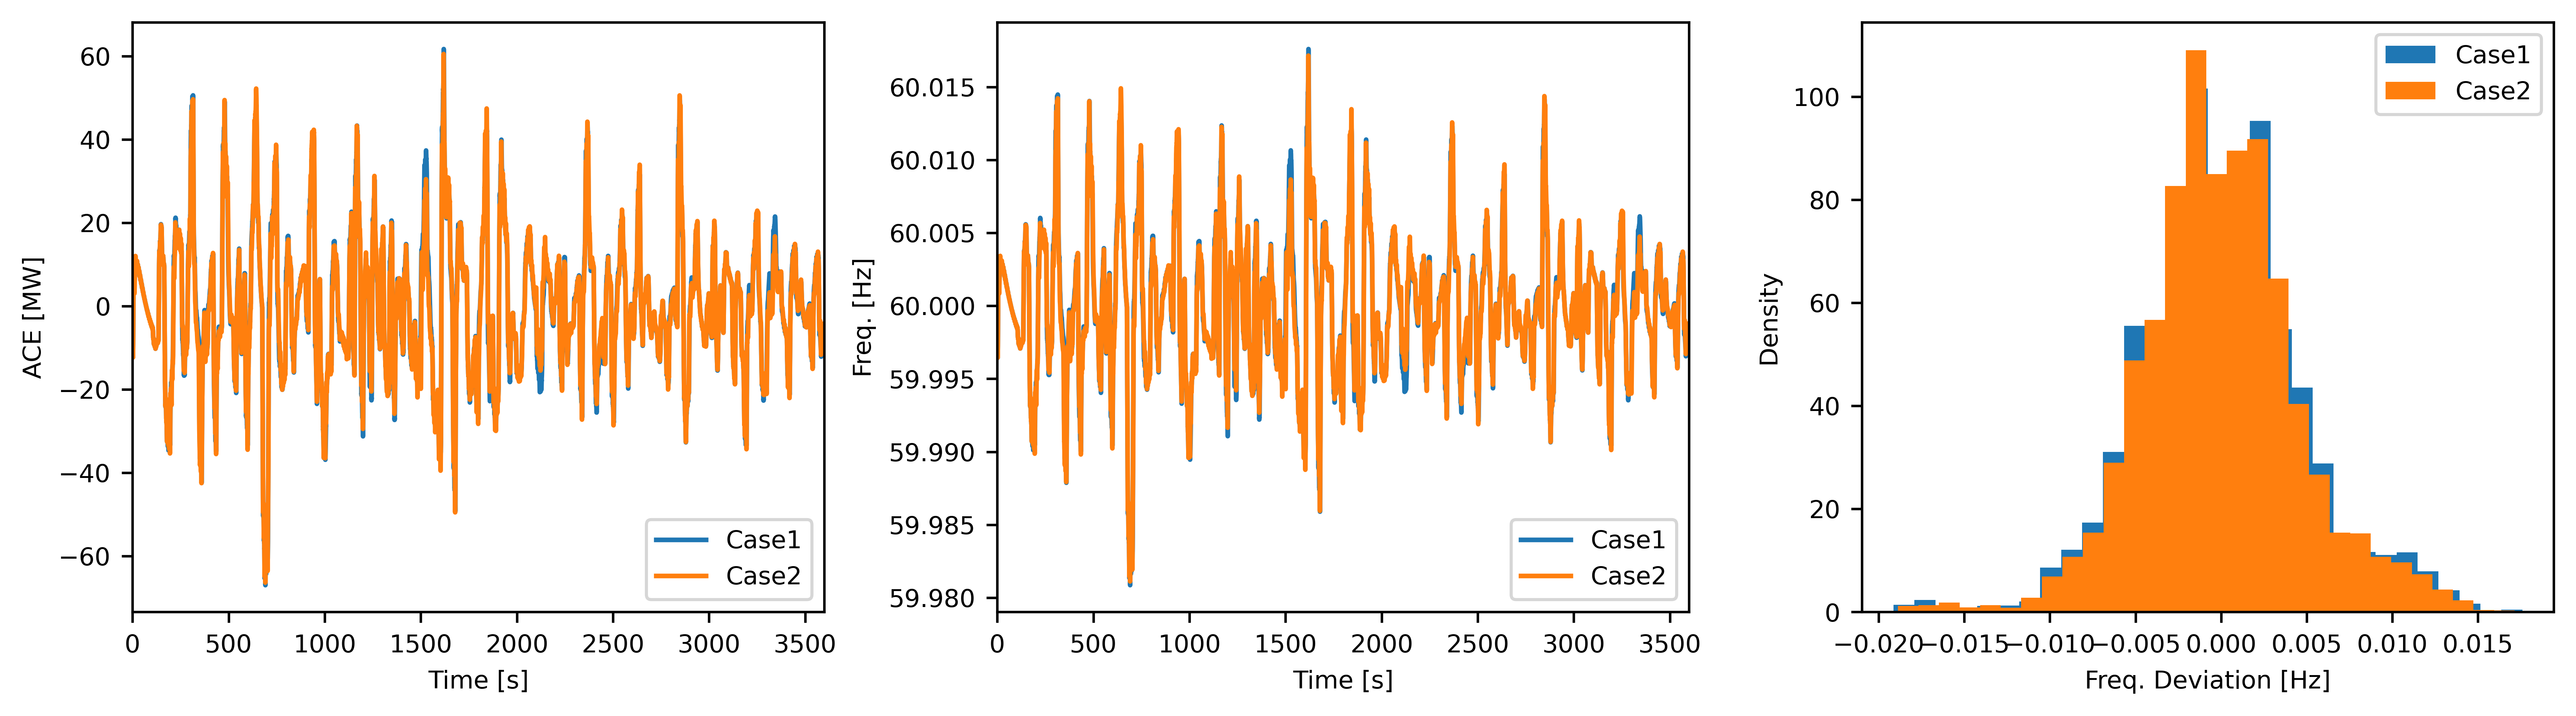

In [13]:
outf['fd'] = outf['freq'] - 60
outs['fd'] = outs['freq'] - 60

plt.style.use('ieee')
fig, ax = plt.subplots(1, 3, figsize=(14, 3.5))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.25, hspace=None)
# ACE
outs.plot(x='Time', y='ACE', ax=ax[0], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outf.plot(x='Time', y='ACE', ax=ax[0], fig=fig, label='Case2', linestyle='-', color='tab:orange')
# COI freq.
outs.plot(x='Time', y='freq', ax=ax[1], fig=fig, label='Case1', linestyle='-', color='tab:blue')
outf.plot(x='Time', y='freq', ax=ax[1], fig=fig, label='Case2', linestyle='-', color='tab:orange',)
# COI std.
outs.plot(x='Time', y='fd', kind='hist', density=True, bins=30, color='tab:blue',
          legend=False, linewidth=1, 
          fig=fig, ax=ax[2], label='Case1')
outf.plot(x='Time', y='fd', kind='hist', density=True, bins=30, color='tab:orange',
          legend=False, linewidth=1,
          fig=fig, ax=ax[2], label='Case2')

ax[0].set_xlim([0, 3600])
ax[1].set_xlim([0, 3600])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('ACE [MW]')
ax[1].set_ylabel('Freq. [Hz]')
ax[2].set_xlabel('Freq. Deviation [Hz]')
ax[2].set_ylabel('Density')
ax[2].legend()

print(f"Case1: Freq. D. {outs['fd'].std()}, Case2: {outf['fd'].std()}")
print(f"Case1: ACE D. {outs['ACE'].std()}, Case2: {outf['ACE'].std()}")

/tmp/ipykernel_2202028/1216912222.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


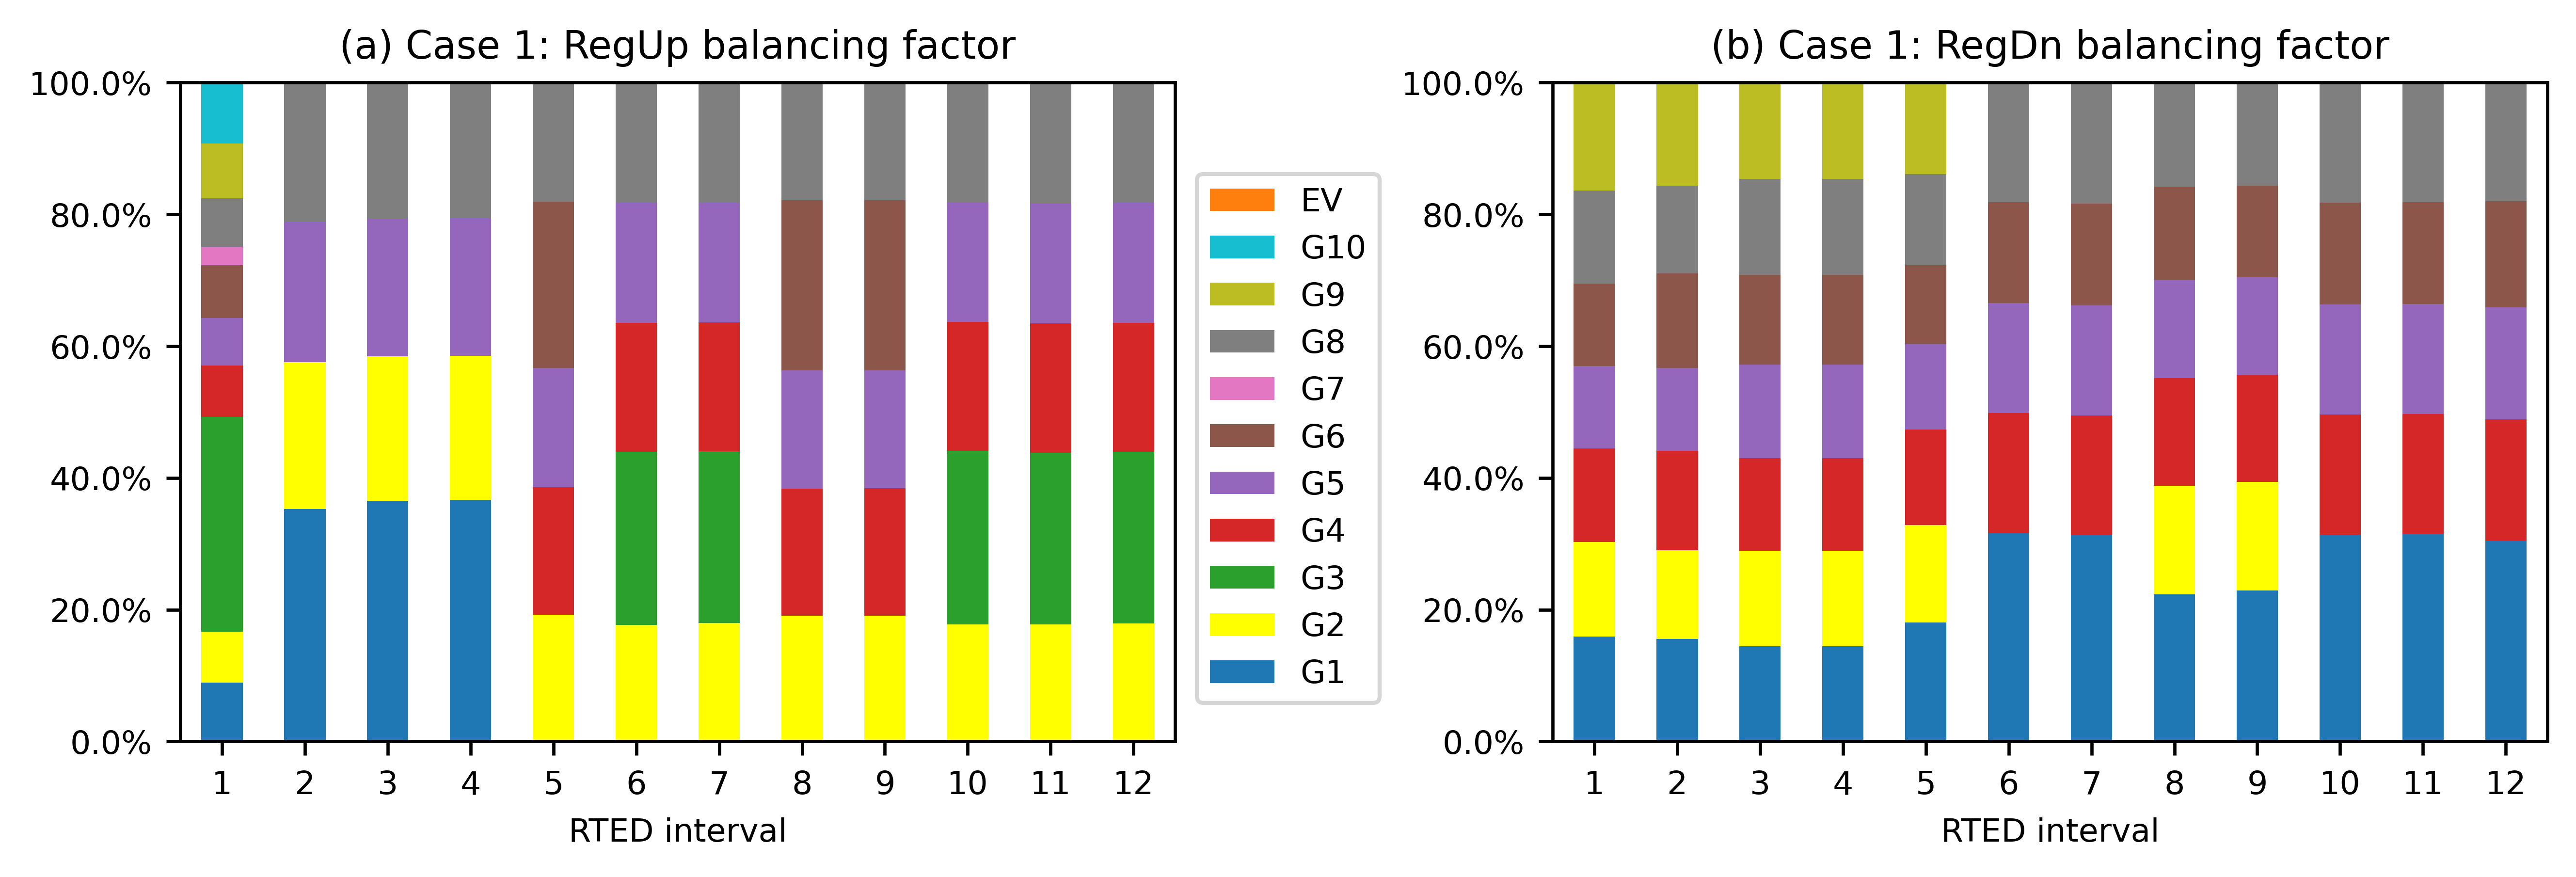

In [14]:
plt.style.use('ieee')

bu_df = pd.read_csv('cosim_18_S_bu.csv')
bd_df = pd.read_csv('cosim_18_S_bd.csv')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case 1: RegUp balancing factor')
axes[1].set_title('(b) Case 1: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

/tmp/ipykernel_2202028/4068592367.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])


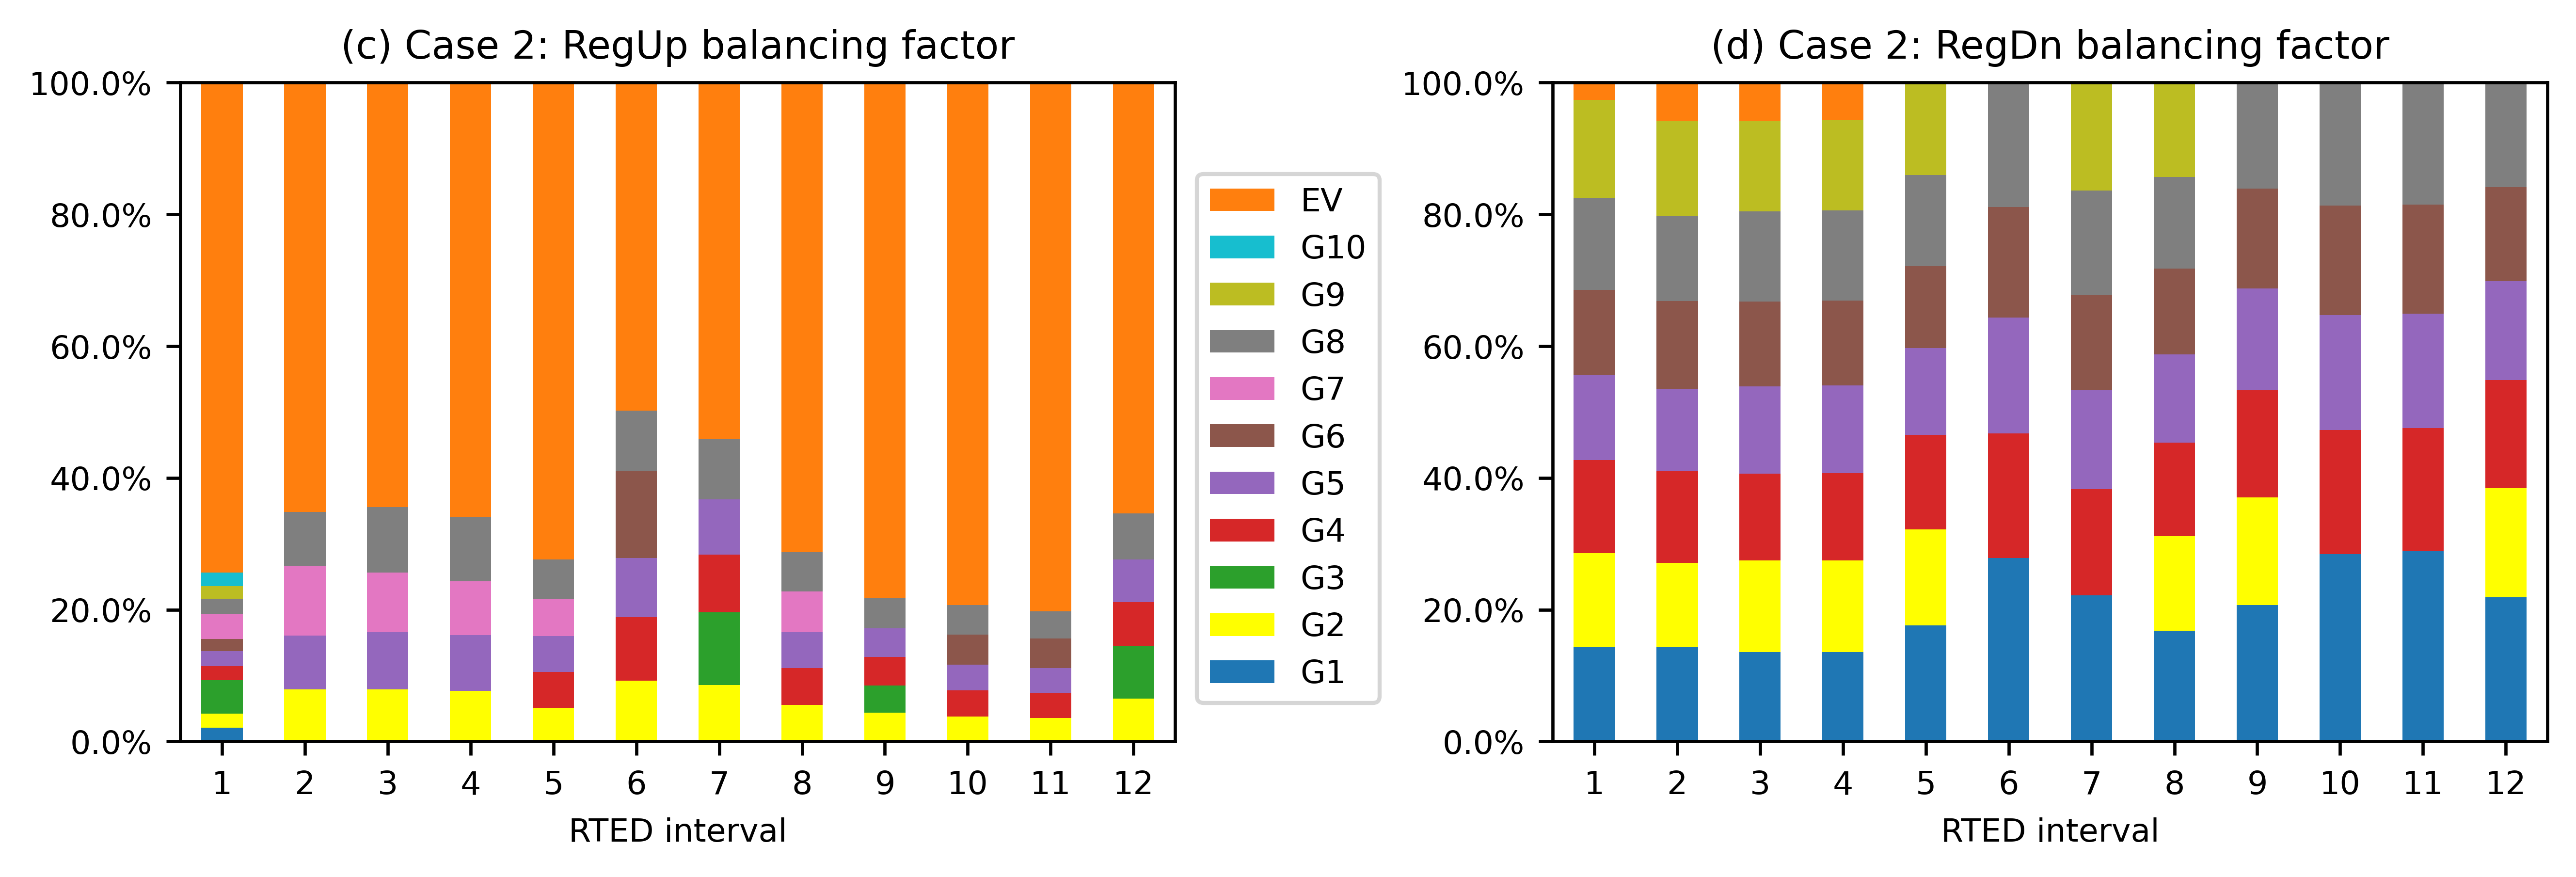

In [15]:
plt.style.use('ieee')

bu_df = pd.read_csv('cosim_18_F_bu.csv')
bd_df = pd.read_csv('cosim_18_F_bd.csv')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.38, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(c) Case 2: RegUp balancing factor')
axes[1].set_title('(d) Case 2: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')